In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib
from sklearn.cluster import KMeans

import common.loss_utils as loss_utils

import sys
sys.path.append('../utae-paps')
from src.backbones import utae_mod

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
EXPECTED = 1


In [5]:
_cluster_centers = np.array(
  [[494.5411  ],
  [125.75024 ],
  [321.87573 ],
  [192.39209 ],
  [256.2398  ],
  [ 55.367462],
  [605.27045 ],
  [405.747   ]], dtype=np.float32
)

_KM = KMeans()
_KM.cluster_centers_ = _cluster_centers
_KM._n_threads = 1

_MEDIAN_PIXEL = 216.0
_IQR = 201.0

def transform(x):
    return (x - _MEDIAN_PIXEL) / _IQR

def transform_y(y):
    y = y.astype(np.float32)
    y_grouped = _KM.predict(y.reshape(-1,1))
    y_grouped = y_grouped.reshape(y.shape)
    return y_grouped

In [6]:
model = utae_mod.UTAE(
    input_dim=1, # 10 for paper
    encoder_widths=[64, 64, 64, 128],
    decoder_widths=[32, 32, 64, 128],
    out_conv=[32, len(_cluster_centers)], # [32, 20] for paper
    str_conv_k=4,
    str_conv_s=2,
    str_conv_p=1,
    agg_mode="att_group",
    encoder_norm="group",
    n_head=16,
    d_model=256,
    d_k=4,
    encoder=False,
    return_maps=False,
    pad_value=0,
    padding_mode="reflect",
)

model.load_state_dict(torch.load("weights/utae_300d_epochs=11_loss=0.1083.pt"))
model = model.to(DEVICE)

../utae-paps/src/backbones/positional_encoding.py:12: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  T, 2 * (torch.arange(offset, offset + d).float() // 2) / d


In [7]:
p = pathlib.Path('data/data_random_300.npz')
f = np.load(p)
times = f['times']
data = f['data']

In [8]:
times.shape, data.shape

((18354,), (18354, 325, 400))

In [ ]:
# data = data[:,375:700-128,550:950-128]

In [15]:
def check_times(tstart, tend):
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

_MEDIAN_PIXEL = 216.0
_IQR = 201.0

def transform(x):
    return (x - _MEDIAN_PIXEL) / _IQR

def transform_y(y):
    y = y.astype(np.float32)
    y_grouped = _KM.predict(y.reshape(-1,1))
    y_grouped = y_grouped.reshape(y.shape)
    return y_grouped

class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, times, data, random_state=7):
        self.times = times
        self.data = data
        self.generator = np.random.RandomState(random_state)

    def _get_crop(self, input_slice, target_slice):
        # roughly over the mainland UK
        rand_x = self.generator.randint(0, input_slice.shape[2] - 128)
        rand_y = self.generator.randint(0, input_slice.shape[1] - 128)

        # make a data selection
        in_crop = input_slice[:, rand_y : rand_y + 128, rand_x : rand_x + 128]
        target_crop = target_slice[
            :, rand_y + 32 : rand_y + 96, rand_x + 32 : rand_x + 96
        ]

        return in_crop, target_crop

    def __getitem__(self, index):
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((index + 35) % len(self))
        src = data[index:index+12]
        trg = data[index+12:index+36]
        x, y = self._get_crop(src, trg)
        x_trans = transform(x)
        y_trans = transform_y(y)
        return x_trans, y_trans, y

    def __len__(self):
        return len(self.times) - 35

BATCH_SIZE=8
ds = CustomTensorDataset(times, data)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=2,
  )



In [10]:
ex_x, ex_y, _ = ds[0]

In [11]:
ex_x.shape, ex_y.shape

((12, 128, 128), (24, 64, 64))

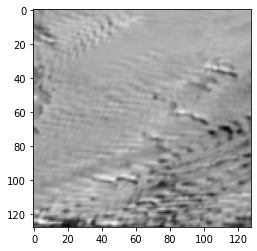

In [12]:
plt.imshow(ex_x[-1], cmap='gray')

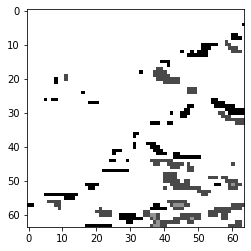

In [13]:
plt.imshow(ex_y[0], cmap='gray')

In [31]:
STOP_BATCH = 500


In [37]:
# get accuracy
model.eval()

running_correct = 0
running_total = 0
bp = torch.Tensor([list(range(12)) for _ in range(BATCH_SIZE)]).to(DEVICE)
pbar = tqdm.tqdm(dl)
for i, (srcs, trgs, _) in enumerate(pbar):
    if i > STOP_BATCH:
        break
    batch_bp = bp[:len(srcs)] # adapt to current batch
    xi = srcs.float().to(DEVICE)
    yi = trgs[:,:EXPECTED].long().to(DEVICE)
    
    xi = torch.unsqueeze(xi, dim=2)
    with torch.no_grad():
        preds = model(xi, batch_positions=bp)
    
    # get argmax of the predicted labels
    preds = torch.argmax(preds, dim=1)
    yi = torch.squeeze(yi, dim=1)
    running_correct += (preds == yi).sum().item()
    running_total += yi.reshape(-1).shape[0]
    if i % 5:
        avg = (running_correct/running_total)
        avg = round(avg, 4)
        pbar.set_description(f'Avg: {avg}')
    


Avg: 0.6456:   3%|▎         | 68/2290 [00:16<08:06,  4.57it/s]


Avg: 0.6562:   6%|▌         | 137/2290 [00:31<08:22,  4.28it/s]


Avg: 0.6569:   9%|▉         | 204/2290 [00:47<07:41,  4.52it/s]


Avg: 0.6581:  12%|█▏        | 272/2290 [01:02<07:52,  4.27it/s]


Avg: 0.6579:  15%|█▍        | 340/2290 [01:17<07:45,  4.19it/s]


Avg: 0.6591:  18%|█▊        | 408/2290 [01:33<07:22,  4.25it/s]


Avg: 0.6574:  21%|██        | 476/2290 [01:48<06:51,  4.41it/s]


Avg: 0.6568:  22%|██▏       | 501/2290 [01:54<06:50,  4.36it/s]


In [38]:
running_correct / running_total

0.6567943215132236

In [41]:
_means = torch.FloatTensor(_cluster_centers).to(DEVICE)
_means = torch.unsqueeze(torch.unsqueeze(_means, 0), 3)

def get_img(preds):
    a = torch.exp(preds)
    v = a.sum(dim=1)
    e = a / torch.unsqueeze(v, 1)
    r = torch.sum(e * _means, axis=1)
    return r

In [42]:
criterion = loss_utils.MS_SSIM(
    data_range=1023.0, size_average=True, win_size=3, channel=EXPECTED)


In [50]:
model.eval()

losses = []
bp = torch.Tensor([list(range(12)) for _ in range(BATCH_SIZE)]).to(DEVICE)
pbar = tqdm.tqdm(dl)
for i, (srcs, _, trgs) in enumerate(pbar):
    if i > STOP_BATCH:
        break
    batch_bp = bp[:len(srcs)] # adapt to current batch
    xi = srcs.float().to(DEVICE)
    yi = trgs[:,:EXPECTED].float().to(DEVICE)
    
    xi = torch.unsqueeze(xi, dim=2)
    with torch.no_grad():
        preds = model(xi, batch_positions=bp)
    
    preds = get_img(preds)
    preds = torch.unsqueeze(preds, dim=1)
    
#     missing = EXPECTED - FORECAST
#     # just do persistence
#     missing_pred = inv_transform(xi[:,-1,:,32:96,32:96])
#     missing_pred = torch.squeeze(missing_pred)
#     missing_pred = torch.tile(missing_pred, (missing, 1, 1))
#     # stack them together
#     preds = torch.cat([preds, missing_pred], dim=0)

    # OR, just test the ones we did
#     yi = yi[:FORECAST]
    
    # also need to do this
    loss = criterion(preds, yi)
    losses.append(loss.item())
    
    if i % 10:
        avg = np.mean(losses)
        avg = round(avg, 4)
        pbar.set_description(f'Avg: {avg}')


Avg: 0.7853:   3%|▎         | 65/2290 [00:17<09:21,  3.96it/s]


Avg: 0.7839:   6%|▌         | 130/2290 [00:33<07:59,  4.50it/s]


Avg: 0.7853:   8%|▊         | 194/2290 [00:49<08:46,  3.98it/s]


Avg: 0.7839:  11%|█▏        | 258/2290 [01:05<08:34,  3.95it/s]


Avg: 0.7848:  14%|█▍        | 323/2290 [01:20<08:34,  3.83it/s]


Avg: 0.7849:  17%|█▋        | 387/2290 [01:37<08:43,  3.63it/s]


Avg: 0.7838:  20%|█▉        | 451/2290 [01:54<08:17,  3.70it/s]


Avg: 0.7839:  22%|██▏       | 501/2290 [02:08<07:38,  3.90it/s]


In [51]:
np.mean(losses)

0.7839452997891013

In [55]:
preds.shape

torch.Size([8, 1, 64, 64])

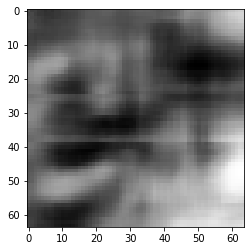

In [53]:
plt.imshow(preds[0,0].detach().cpu().numpy(), cmap='gray')

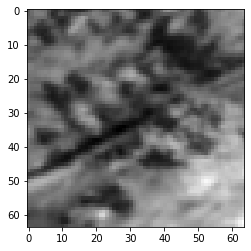

In [56]:
plt.imshow(yi[0,0].detach().cpu().numpy(), cmap='gray')

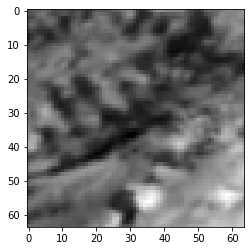

In [57]:
plt.imshow(xi[0,-1,0][32:96,32:96].detach().cpu().numpy(), cmap='gray')